### <b>Code</b>

#### 1) Import data into pandas DataFrame

Get only the necessary columns (and rename them so they can be referred to more easily).

In [14]:
from pathlib import Path
import pandas as pd

PATH = Path("Datafiniti_Hotel_Reviews_Jun19.csv")
df = pd.read_csv(
    PATH, 
    usecols=[
        'id', 
        'reviews.rating', 
        'reviews.title', 
        'reviews.text',
    ],
)

df.rename(
    columns = {
        'id': 'hotel_id',
        'reviews.rating': 'rating',
        'reviews.title': 'title',
        'reviews.text': 'text',
    }, 
    inplace = True
) 

Drop duplicate rows.

In [15]:
og_row_count = df.shape[0]
df = df.drop_duplicates()
new_row_count = df.shape[0]

num_duplicates = og_row_count - new_row_count
print("Dropped {0} duplicate columns".format(num_duplicates))

Dropped 213 duplicate columns


Get a subset of this dataframe - keep only the rows for the most-reviewed hotel.

In [16]:
# find most-reviewed hotel (check by id)
hotel_id = df.hotel_id.value_counts().index[0]

# create df for this hotel and drop [now] redundant 'hotel_id' col
df_hotel = df[df.hotel_id == hotel_id].drop(columns='hotel_id')
df_hotel.head(3)

,rating,text,title
7759,5,"I stayed here for a vacation, hoping to enjoy ...","Location, amenities, and great service!"
7760,5,"To describe who is writing this, I was a singl...",Fabulous Hotel under the space needle
7761,3,The room was nice and modern. Parking is VERY ...,Across from Space Needle but Overpriced


#### 2) Visualize the data

Plot ratings in a histogram.

NameError: name 'df_hotel' is not defined

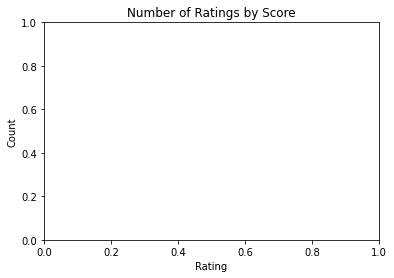

In [4]:
import matplotlib.pyplot as plt

plt.title('Number of Ratings by Score')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.hist(
    df_hotel["rating"], 
    bins=[1, 2, 3, 4, 5, 6],
    align='left',
    color='blue',
    edgecolor='black'
)
plt.grid(
    axis='y',
    alpha=0.5
)

plt.plot()

In [ ]:
# an alternative, interactive histogram (for use in jupyter)
import plotly.express as px

fig = px.histogram(
    df_hotel['rating'],
    x="rating",
    title='Ratings Count',
    labels={'rating': 'Rating'},
    opacity=0.8,
    color_discrete_sequence=['blue'] # color of histogram bars
)

fig.show()

#### 3) Cleanse the data

For the title and text columns:
1. Remove long, unwanted strings (in this case, responses to reviews by hotel management)
2. Tokenize
3. Remove stopwords
4. Remove other irrelevant words
5. Stem words

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re


def remove_mgmt_response(reviews_text: str) -> str:
    """
    Remove management's response from review, return review.
    
    Keyword arguments:
    reviews_text -- text from all reviews as one long string
    """
    # remove substring: feedback from Sarah Junge and Jonathan
    reviews_text = re.sub(
        r'(Feedback from our guests|,Thank|, Thank|,We|, We|Dear)'  # starts w/
        + '(.*?)'  # include substring between beginning/end
        + '(Sarah Junge|Jonathan)',  # ends w/
        '', 
        reviews_text)
    
    reviews_text = re.sub(
        r'(It was a pleasure|Thank you for completing)'
        + '(.*?)'
        + '(Sarah Junge|Jonathan)',
        '', 
        reviews_text)
    
    # remove substring: feedback from unknown author(s)
    reviews_text = re.sub(
        r'Hello(.*?)(good nights sleep!|wherever you go!)', 
        '', 
        reviews_text)
    
    reviews_text = re.sub(
        r'Thank you for taking(.*?)(Cheers!|Seattle!)', 
        '', 
        reviews_text)
    
    reviews_text = re.sub(
        r'Thank you for sharing(.*?)(soon!)', 
        '', 
        reviews_text)
    
    return reviews_text


def cleanse_df_columns(
        df: pd.DataFrame, 
        cols: [str], 
        cleaner_function: object, 
        filter_list: [str] = []) -> pd.DataFrame:
    """Prepare df column(s) for vectorization and return as a new df.
    
    For each column: remove long, unwanted strings; tokenize; remove 
    stopwords; stem words; and remove stems of words found in stemmed 
    filter list, in that order.
    
    keyword arguments:
    df -- dataframe to tokenize
    cols -- name of column(s) to be tokenized
    cleaner_function -- function specialized for each particular 
    dataset that removes long, unwanted strings
    filter_list -- words whose stems will be removed from column(s)
    """
    tokenized_df = df.copy()
    tokenizer = RegexpTokenizer(r'\w+')  # removes punctuation
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    
    # get stems of words in filter list
    filter_list_stems = [ps.stem(word) for word in filter_list]
    
    for col in cols:
        
        # remove long strings
        tokenized_df[col] = tokenized_df[col].apply(
            lambda row: cleaner_function(str(row)))
        # tokenize
        tokenized_df[col] = tokenized_df.apply(
            lambda row: tokenizer.tokenize(row[col].lower()), axis=1)
        # remove stopwords
        tokenized_df[col] = tokenized_df[col].apply(
            lambda tokens: [word for word in tokens if word not in stop_words])
        # stem words
        tokenized_df[col] = tokenized_df[col].apply(
            lambda tokens: [ps.stem(word) for word in tokens])
        # remove filter list word stems
        tokenized_df[col] = tokenized_df[col].apply(
            lambda stems: [
                stem for stem in stems if stem not in filter_list_stems])
        
    return tokenized_df


filter_list = ['hotel', 'hyatt', 'house', 'room', 'night', 'stay', 
               'day', 'get', 'back', 'ask', 'time', 'would', 'one', 
               'left', 'next', 'said', 'told', 'could', 'go', 'take',
               '1', '2', '4', '5', '6']

df_hotel_tokenized = cleanse_df_columns(
    df_hotel, ['text', 'title'], remove_mgmt_response, filter_list)
df_hotel_tokenized.head(3)

,rating,text,title
7759,5,"[vacat, hope, enjoy, locat, receiv, much, good...","[locat, amen, great, servic]"
7760,5,"[describ, write, singl, travel, 3, person, par...","[fabul, space, needl]"
7761,3,"[nice, modern, park, limit, hard, park, small,...","[across, space, needl, overpr]"


#### 4) Classify the data

Sort into two dataframes:
- unfavourable reviews (rating of 1, 2, or 3)
- favourable reviews (rating of 4 or 5)

<font color=lightgrey>Author's note: In retrospect, I should have kept reviews in one dataframe and added a column "favourable" that takes a binary value (bit is set to 1 if rating is 1, 2, or 3). Here, I thought it would be cleaner to view unfavourable/favourable n-grams in separate dataframes. I could have accomplished the same thing with a single dataframe by just viewing unfavourable/favourable n-gram columns at separate times.</font>

In [19]:
unfav_rate = [1, 2, 3]
fav_rate = [4, 5]

df_hotel_unfav = df_hotel_tokenized[
    df_hotel_tokenized['rating'].isin(unfav_rate)].drop(columns='rating')

df_hotel_fav = df_hotel_tokenized[
    df_hotel_tokenized['rating'].isin(fav_rate)].drop(columns='rating')

#### 5) Find n-grams

Find n-grams of size 1-5 for title and text columns.

In [20]:
from collections import Counter
from nltk.util import ngrams

    
def get_ngrams(
        df: pd.DataFrame, 
        cols: [str], 
        ngram_max_size: int = 5,
        min_ngram_freq: int = 2,
        max_ngrams: int = 80) -> pd.DataFrame:
    """Get n-grams from dataframe column(s) and return a dataframe of 
    n-grams and their frequency (descending order).
    
    keyword arguments:
    df -- dataframe to get n-grams from
    cols -- name of column(s) to get n-grams from
    ngram_max_size -- maximum n-gram size to get
    min_ngram_freq -- minimum frequency of n-grams (before inclusion)
    max_ngrams -- maximum number of n-grams to return
    """
    # create one long list of words from column(s)
    words = []
    for col in cols:
        df[col].apply(
            lambda tokens: [words.append(word) for word in tokens])
    
    # for each n-gram size, create df for n-grams and their frequencies
    ngram_dfs = []
    for ngram_size in range(1, ngram_max_size + 1):

        # count n-gram occurrences
        ngram_frequency_list = Counter(
            ngrams(words, ngram_size)).most_common(max_ngrams)  

        frequencies = []
        ngrams_list = []

        # ignore those n-grams below the required frequency
        for i in range(0, len(ngram_frequency_list)):
            if (ngram_frequency_list[i][1] >= min_ngram_freq):        
                frequencies.append(ngram_frequency_list[i][1])
                ngrams_list.append(' '.join(ngram_frequency_list[i][0]))

        ngram_data = {
            'frequency': frequencies, 
        }

        # get column name for n-grams, based on n-gram size
        if ngram_size == 1:
            ngram_name = 'unigram'
        elif ngram_size == 2:
            ngram_name = 'bigram'
        elif ngram_size == 3:
            ngram_name = 'trigram'
        else:
            ngram_name = str(ngram_size) + 'gram'

        ngram_data.update({ngram_name: ngrams_list})
        ngram_dfs.append(pd.DataFrame(ngram_data))
        
    ngram_df = ngram_dfs.pop(0)
    for df in ngram_dfs:
        if len(df.index):
            ngram_df = ngram_df.append(df)
    
    ngram_df = ngram_df.sort_values(
        by='frequency', ascending=False).reset_index(drop=True)
    return ngram_df


df_unfav_ngrams = get_ngrams(df_hotel_unfav, ['title', 'text'], 5, 3)
df_fav_ngrams = get_ngrams(df_hotel_fav, ['title', 'text'], 5, 5)

In [21]:
df_unfav_ngrams

,frequency,unigram,bigram,trigram
0,23,park,NaN,NaN
1,17,clean,NaN,NaN
2,16,check,NaN,NaN
3,16,call,NaN,NaN
4,15,staff,NaN,NaN
...,...,...,...,...
86,3,NaN,card charg,NaN
87,3,NaN,hot water,NaN
88,3,NaN,answer phone,NaN
89,3,NaN,park lot,NaN


In [22]:
df_fav_ngrams

,frequency,unigram,bigram,trigram,4gram,5gram
0,157,great,NaN,NaN,NaN,NaN
1,128,locat,NaN,NaN,NaN,NaN
2,111,breakfast,NaN,NaN,NaN,NaN
3,108,space,NaN,NaN,NaN,NaN
4,106,staff,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
172,5,NaN,omelet bar,NaN,NaN,NaN
173,5,NaN,park garag,NaN,NaN,NaN
174,5,NaN,minut walk,NaN,NaN,NaN
175,5,NaN,earli check,NaN,NaN,NaN
